***MONTAGE DE GOOGLE DRIVE ET CHARGEMENT DU MODÈLE***

In [1]:
# Montages et configurations initiales
from google.colab import drive  # Importation de la bibliothèque pour monter Google Drive dans Colab
drive.mount('/content/drive', force_remount=True) # Monte le Google Drive dans l'environnement Colab pour accéder aux fichiers.

# Décompression des données depuis Google Drive
!unzip -q "/content/drive/MyDrive/Data/plantvillage_dataset/color_split.zip" -d "/content/" # Décompresse l'archive contenant le dataset.

Mounted at /content/drive


***IMPORTATION DES LIBRAIRIES***

In [2]:
import os  # Gestion des chemins et des fichiers.
import numpy as np  # Manipulation des données numériques et des tableaux.
import matplotlib.pyplot as plt  # Visualisation des données et des courbes.
import tensorflow as tf  # Framework de deep learning.
from tensorflow import keras  # Module pour créer des modèles de machine learning.
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  # Couches utilisées dans le modèle.
from tensorflow.keras.models import Model  # API fonctionnelle pour construire des modèles.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Callbacks pour gérer l'entraînement.
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Génération et augmentation d'images.
from tensorflow.keras.regularizers import l2  # Régularisation pour éviter l'overfitting.
from tensorflow.keras.applications import MobileNetV2  # Modèle pré-entraîné MobileNetV2.
from sklearn.metrics import confusion_matrix, classification_report  # Évaluation des performances du modèle.
import datetime  # Gestion des dates pour nommer les fichiers.
import json  # Sauvegarde des historiques d'entraînement.

***DÉFINITION DES CHEMINS DACCÈS AUX DONNÉES***

In [3]:
train_path = '/content/color_split/train'  # Chemin des données d'entraînement.
val_path = '/content/color_split/val'  # Chemin des données de validation.
test_path = '/content/color_split/test'  # Chemin des données de test.
mob_path = '/content/drive/MyDrive/MOB/'  # Dossier pour sauvegarder les résultats et modèles.

# Vérification des répertoires
print("Train path exists:", os.path.exists(train_path))  # Vérifie l'existence des données d'entraînement.
print("Validation path exists:", os.path.exists(val_path))  # Vérifie l'existence des données de validation.
print("Test path exists:", os.path.exists(test_path))  # Vérifie l'existence des données de test.
if not os.path.exists(mob_path):
    os.makedirs(mob_path)  # Crée le dossier de sauvegarde s'il n'existe pas.

Train path exists: True
Validation path exists: True
Test path exists: True


***PRÉPARATION DES GÉNÉRATEURS DIMAGES***

In [4]:
train_data_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,  # Prétraitement spécifique à MobileNetV2.
    rotation_range=10,  # Augmentation : rotation des images jusqu'à 10°.
    width_shift_range=0.1,  # Augmentation : décalage horizontal.
    height_shift_range=0.1,  # Augmentation : décalage vertical.
    shear_range=0.1,  # Augmentation : transformation en cisaillement.
    zoom_range=0.1,  # Augmentation : zoom sur les images.
    horizontal_flip=True,  # Augmentation : retournement horizontal.
    fill_mode='nearest'  # Mode de remplissage des pixels manquants.
)

val_test_data_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input  # Prétraitement sans augmentation.
)

train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(96, 96),  # Redimensionne les images à 96x96 pixels.
    batch_size=16,  # Nombre d'images par lot.
    class_mode='categorical'  # Les classes sont représentées sous forme catégorielle.
)

val_generator = val_test_data_generator.flow_from_directory(
    val_path,
    target_size=(96, 96),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Pas de mélange des données pour l'évaluation.
)
test_generator = val_test_data_generator.flow_from_directory(
    test_path,
    target_size=(96, 96),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Pas de mélange des données pour l'évaluation.
)


Found 43429 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


***CONFIGURATION DES CALLBACKS***

In [5]:
checkpoint_best = ModelCheckpoint(
    filepath=f'{mob_path}Anas_Essai_1_MOB_L2.keras',  # Sauvegarde du meilleur modèle.
    monitor='val_accuracy',  # Surveille l'exactitude de validation.
    save_best_only=True,  # Sauvegarde uniquement si c'est le meilleur modèle.
    mode='max',  # Cherche à maximiser l'exactitude.
    verbose=1  # Affiche les logs.
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveille la perte de validation.
    patience=5,  # Arrête si aucune amélioration pendant 5 époques.
    verbose=1,  # Affiche les logs.
    restore_best_weights=True  # Restaure les meilleurs poids.
)

***CONSTRUCTION DU MODÈLE AVEC MOBILENETV2 AVEC L2***

In [6]:
# Construction du modèle MobileNetV2 avec régularisation L2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))  # Modèle pré-entraîné sans couche de sortie.
base_model.trainable = True  # Débloque les couches pour le fine-tuning.

# Sélection des couches à débloquer
for layer in base_model.layers[:-20]:  # Gèle toutes les couches sauf les 20 dernières.
    layer.trainable = False

inputs = keras.Input(shape=(96, 96, 3))  # Définition de la forme des entrées.
x = base_model(inputs, training=False)  # Utilise le modèle de base comme extracteur de caractéristiques.
x = GlobalAveragePooling2D()(x)  # Réduit les dimensions tout en conservant les informations principales.
x = Dropout(0.2)(x)  # Ajoute un dropout pour éviter l'overfitting.
outputs = Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Couche de sortie avec régularisation L2.
model = Model(inputs, outputs)  # Assemble le modèle final.

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])  # Configure l'optimiseur, la fonction de perte et les métriques.
model.summary()  # Affiche le résumé du modèle.

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 38)                  │          48,678 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 1,254,758 (4.79 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

***ENTRAÎNEMENT DU MODÈLE PAR BLOCS***

In [7]:
block_size = 5  # Taille des blocs d'entraînement.
initial_epochs = 20  # Nombre total d'époques pour l'entraînement.
current_date = datetime.datetime.now().strftime("%Y%m%d")  # Date actuelle pour nommer les fichiers.

for i in range(0, initial_epochs, block_size):
    history_block = model.fit(
        train_generator,  # Données d'entraînement.
        epochs=min(i + block_size, initial_epochs),  # Détermine le nombre d'époques pour ce bloc.
        validation_data=val_generator,  # Données de validation.
        callbacks=[checkpoint_best, early_stopping],  # Callbacks pour gérer l'entraînement.
        verbose=1  # Affiche les logs.
    )
    with open(f'{mob_path}history_block_{i + 1}_{current_date}.json', 'w') as f:  # Sauvegarde l'historique du bloc.
        json.dump(history_block.history, f)
    model.save(f'{mob_path}model_l2_after_block_{i + 1}_{current_date}.keras') # Sauvegarde le modèle après chaque bloc.

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7591 - loss: 1.5399
Epoch 1: val_accuracy improved from -inf to 0.92524, saving model to /content/drive/MyDrive/MOB/Anas_Essai_1_MOB_L2.keras
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 670s 243ms/step - accuracy: 0.7591 - loss: 1.5397 - val_accuracy: 0.9252 - val_loss: 0.6027
Epoch 2/5
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9375 - loss: 0.5108
Epoch 2: val_accuracy improved from 0.92524 to 0.94665, saving model to /content/drive/MyDrive/MOB/Anas_Essai_1_MOB_L2.keras
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 647s 238ms/step - accuracy: 0.9375 - loss: 0.5108 - val_accuracy: 0.9466 - val_loss: 0.3578
Epoch 3/5
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9491 - loss: 0.3267
Epoch 3: val_accuracy did not improve from 0.94665
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 651s 240ms/step - accuracy: 0.9491 - loss: 0.3267 - val_accuracy: 0.9420 - val_loss: 0.2934
Epoch 4/5
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9627 - 

KeyboardInterrupt: 

In [9]:
# Chemin vers l'historique partiel du Bloc 3
bloc3_partial_path = f'{mob_path}manual_history_block3_1_to_8_{current_date}.json'

# Charger et vérifier l'historique
with open(bloc3_partial_path, 'r') as f:
    manual_block_3 = json.load(f)

print("Clés dans l'historique du Bloc 3 :", manual_block_3.keys())
print("Nombre d'époques enregistrées :", len(manual_block_3['accuracy']))


Clés dans l'historique du Bloc 3 : dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Nombre d'époques enregistrées : 10


In [11]:
import json

# Chemins vers les fichiers dans le dossier MOB
bloc1_path = '/content/drive/MyDrive/MOB/history_block_1_20241208.json'
bloc2_path = '/content/drive/MyDrive/MOB/history_block_6_20241208.json'
bloc3_partial_path = '/content/drive/MyDrive/MOB/manual_history_block3_1_to_8_20241208.json'

# Charger les historiques
with open(bloc1_path, 'r') as f:
    history_block_1 = json.load(f)

with open(bloc2_path, 'r') as f:
    history_block_2 = json.load(f)

with open(bloc3_partial_path, 'r') as f:
    manual_block_3 = json.load(f)


In [12]:
print("Bloc 1 : ", len(history_block_1['accuracy']))
print("Bloc 2 : ", len(history_block_2['accuracy']))
print("Bloc 3 : ", len(manual_block_3['accuracy']))


Bloc 1 :  5
Bloc 2 :  10
Bloc 3 :  10


*** Funionnement des blocs***

In [13]:
# Fusionner les trois blocs
combined_history = {
    key: history_block_1[key] + history_block_2[key] + manual_block_3[key]
    for key in history_block_1.keys()
}

# Sauvegarder l'historique combiné
combined_path = '/content/drive/MyDrive/MOB/combined_history_25_epochs_20241208.json'
with open(combined_path, 'w') as f:
    json.dump(combined_history, f)

print(f"L'historique global (25 époques) a été sauvegardé dans {combined_path}.")


L'historique global (25 époques) a été sauvegardé dans /content/drive/MyDrive/MOB/combined_history_25_epochs_20241208.json.


In [14]:
# Charger et vérifier le fichier combiné
with open('/content/drive/MyDrive/MOB/combined_history_25_epochs_20241208.json', 'r') as f:
    combined_history = json.load(f)

# Afficher les clés et les premières valeurs
print("Clés dans l'historique global :", combined_history.keys())
print("Premières valeurs de 'accuracy' :", combined_history['accuracy'][:5])
print("Premières valeurs de 'val_accuracy' :", combined_history['val_accuracy'][:5])
print("Total d'époques enregistrées :", len(combined_history['accuracy']))


Clés dans l'historique global : dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Premières valeurs de 'accuracy' : [0.8600013852119446, 0.9395104646682739, 0.9513919353485107, 0.9611319899559021, 0.9621450901031494]
Premières valeurs de 'val_accuracy' : [0.925235390663147, 0.946649432182312, 0.9420343637466431, 0.9468340277671814, 0.9436957836151123]
Total d'époques enregistrées : 25


In [15]:
best_epoch = combined_history['val_accuracy'].index(max(combined_history['val_accuracy'])) + 1
best_val_accuracy = max(combined_history['val_accuracy'])
print(f"Meilleure époque : {best_epoch}, avec val_accuracy = {best_val_accuracy}")


Meilleure époque : 12, avec val_accuracy = 0.9682481288909912


***Tracer les courbes d'apprentissage***

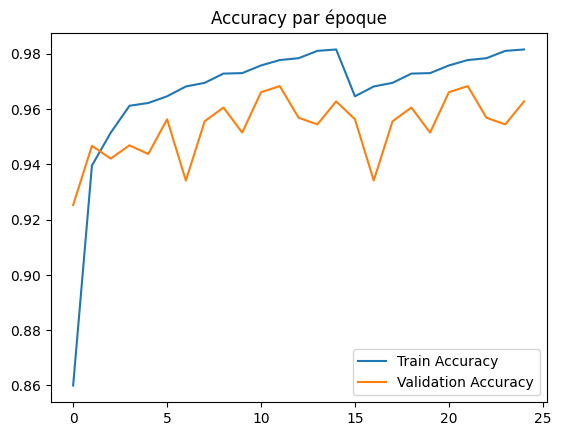

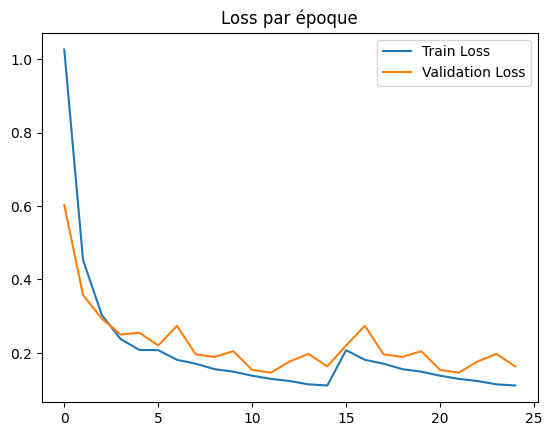

In [16]:
import matplotlib.pyplot as plt

# Tracer les courbes d'accuracy
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy par époque')
plt.show()

# Tracer les courbes de perte
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss par époque')
plt.show()


***Evaluation des modèles***

In [17]:
# Évaluer les performances sur les données de test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


342/342 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.9714 - loss: 0.1351
Test Loss: 0.14769721031188965, Test Accuracy: 0.9675765037536621


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Vraies classes
y_true = test_generator.classes

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion')
plt.show()


***Prédictions et matrice de confusion***

342/342 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.89      0.93        63
                                 Apple___Black_rot       0.85      0.98      0.91        63
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        28
                                   Apple___healthy       0.94      0.99      0.96       165
                               Blueberry___healthy       1.00      1.00      1.00       151
          Cherry_(including_sour)___Powdery_mildew       1.00      0.97      0.99       106
                 Cherry_(including_sour)___healthy       0.98      0.99      0.98        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.78      0.98      0.87        52
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99       120
               Corn_(maize)___North

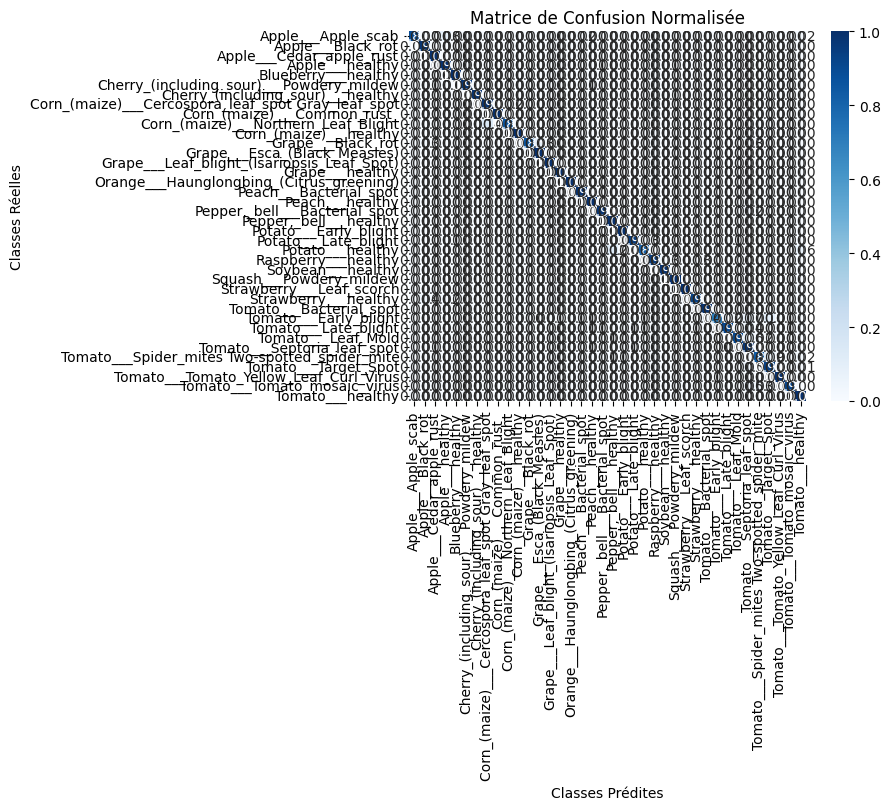

In [19]:
predictions = model.predict(test_generator)  # Prédictions du modèle.
predicted_classes = np.argmax(predictions, axis=1)  # Classes prédites.
true_classes = test_generator.classes  # Classes réelles.
class_labels = list(test_generator.class_indices.keys())  # Noms des classes.

print(classification_report(true_classes, predicted_classes, target_names=class_labels))  # Rapport de classification.

cm = confusion_matrix(true_classes, predicted_classes)  # Matrice de confusion brute.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisation des valeurs.
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)  # Affiche la matrice de confusion.
plt.title("Matrice de Confusion Normalisée")
plt.xlabel("Classes Prédites")
plt.ylabel("Classes Réelles")
plt.savefig(f'{mob_path}confusion_matrix.png')  # Sauvegarde la matrice de confusion.
plt.show()

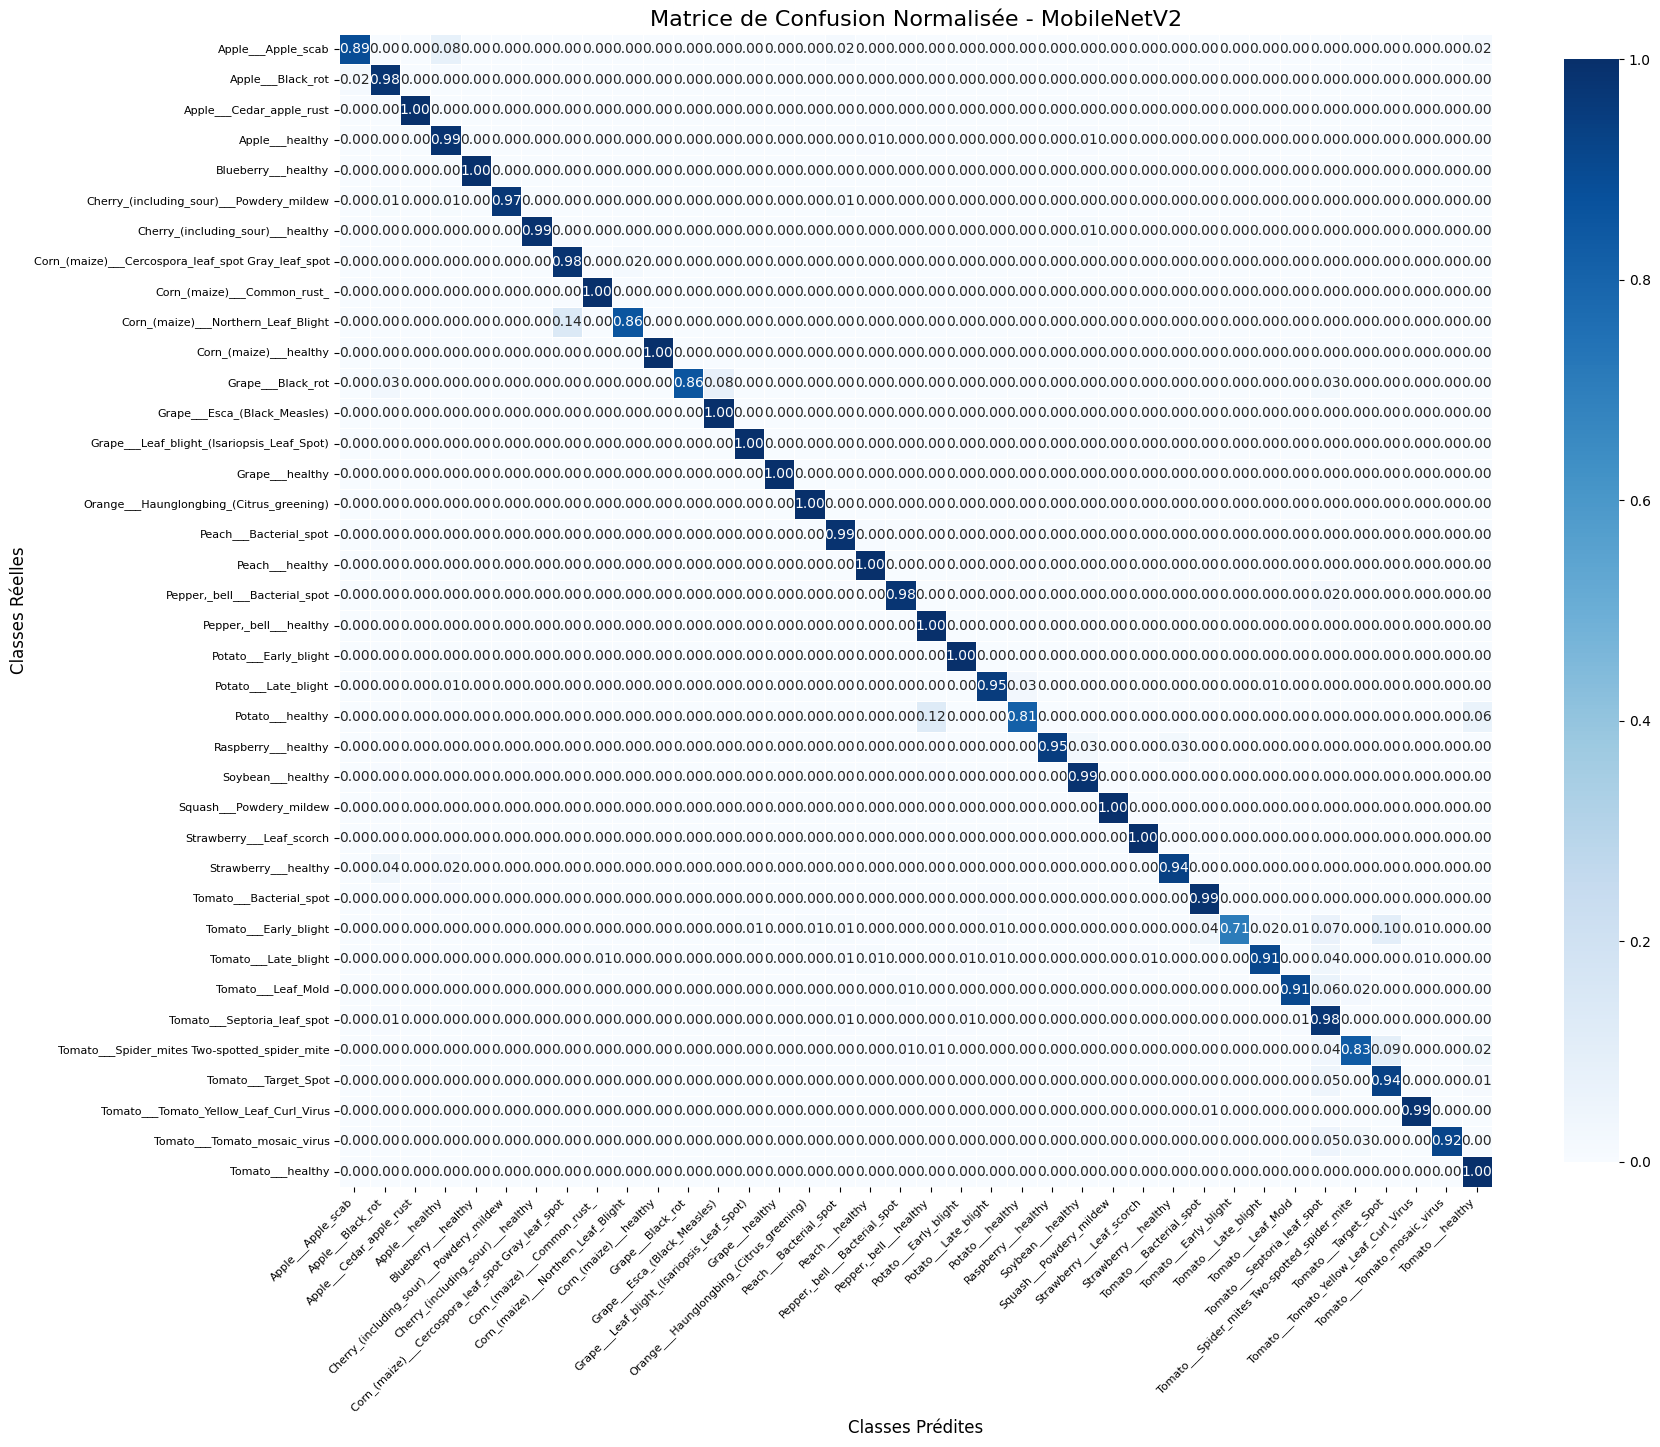

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Générer la matrice de confusion normalisée
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Configurer la taille et les limites d'affichage
plt.figure(figsize=(18, 16))  # Augmenter davantage la taille pour optimiser l'affichage
sns.heatmap(
    cm_normalized,
    annot=True,  # Activer les annotations pour afficher les valeurs
    fmt='.2f',  # Format des valeurs flottantes
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels,
    linewidths=0.5,  # Ajouter des séparations entre les cellules
    square=True,  # Forcer les cellules à être carrées
    cbar_kws={"shrink": 0.8}  # Réduire légèrement la taille de la barre de couleur
)

# Ajuster les étiquettes des axes
plt.xticks(rotation=45, fontsize=8, ha='right')  # Rotation modérée pour éviter le chevauchement
plt.yticks(fontsize=8)

# Titres et légendes
plt.title("Matrice de Confusion Normalisée - MobileNetV2", fontsize=16)
plt.xlabel("Classes Prédites", fontsize=12)
plt.ylabel("Classes Réelles", fontsize=12)

# Sauvegarder et afficher
plt.tight_layout()
plt.savefig('confusion_matrix_improved_v3.png', dpi=300)
plt.show()



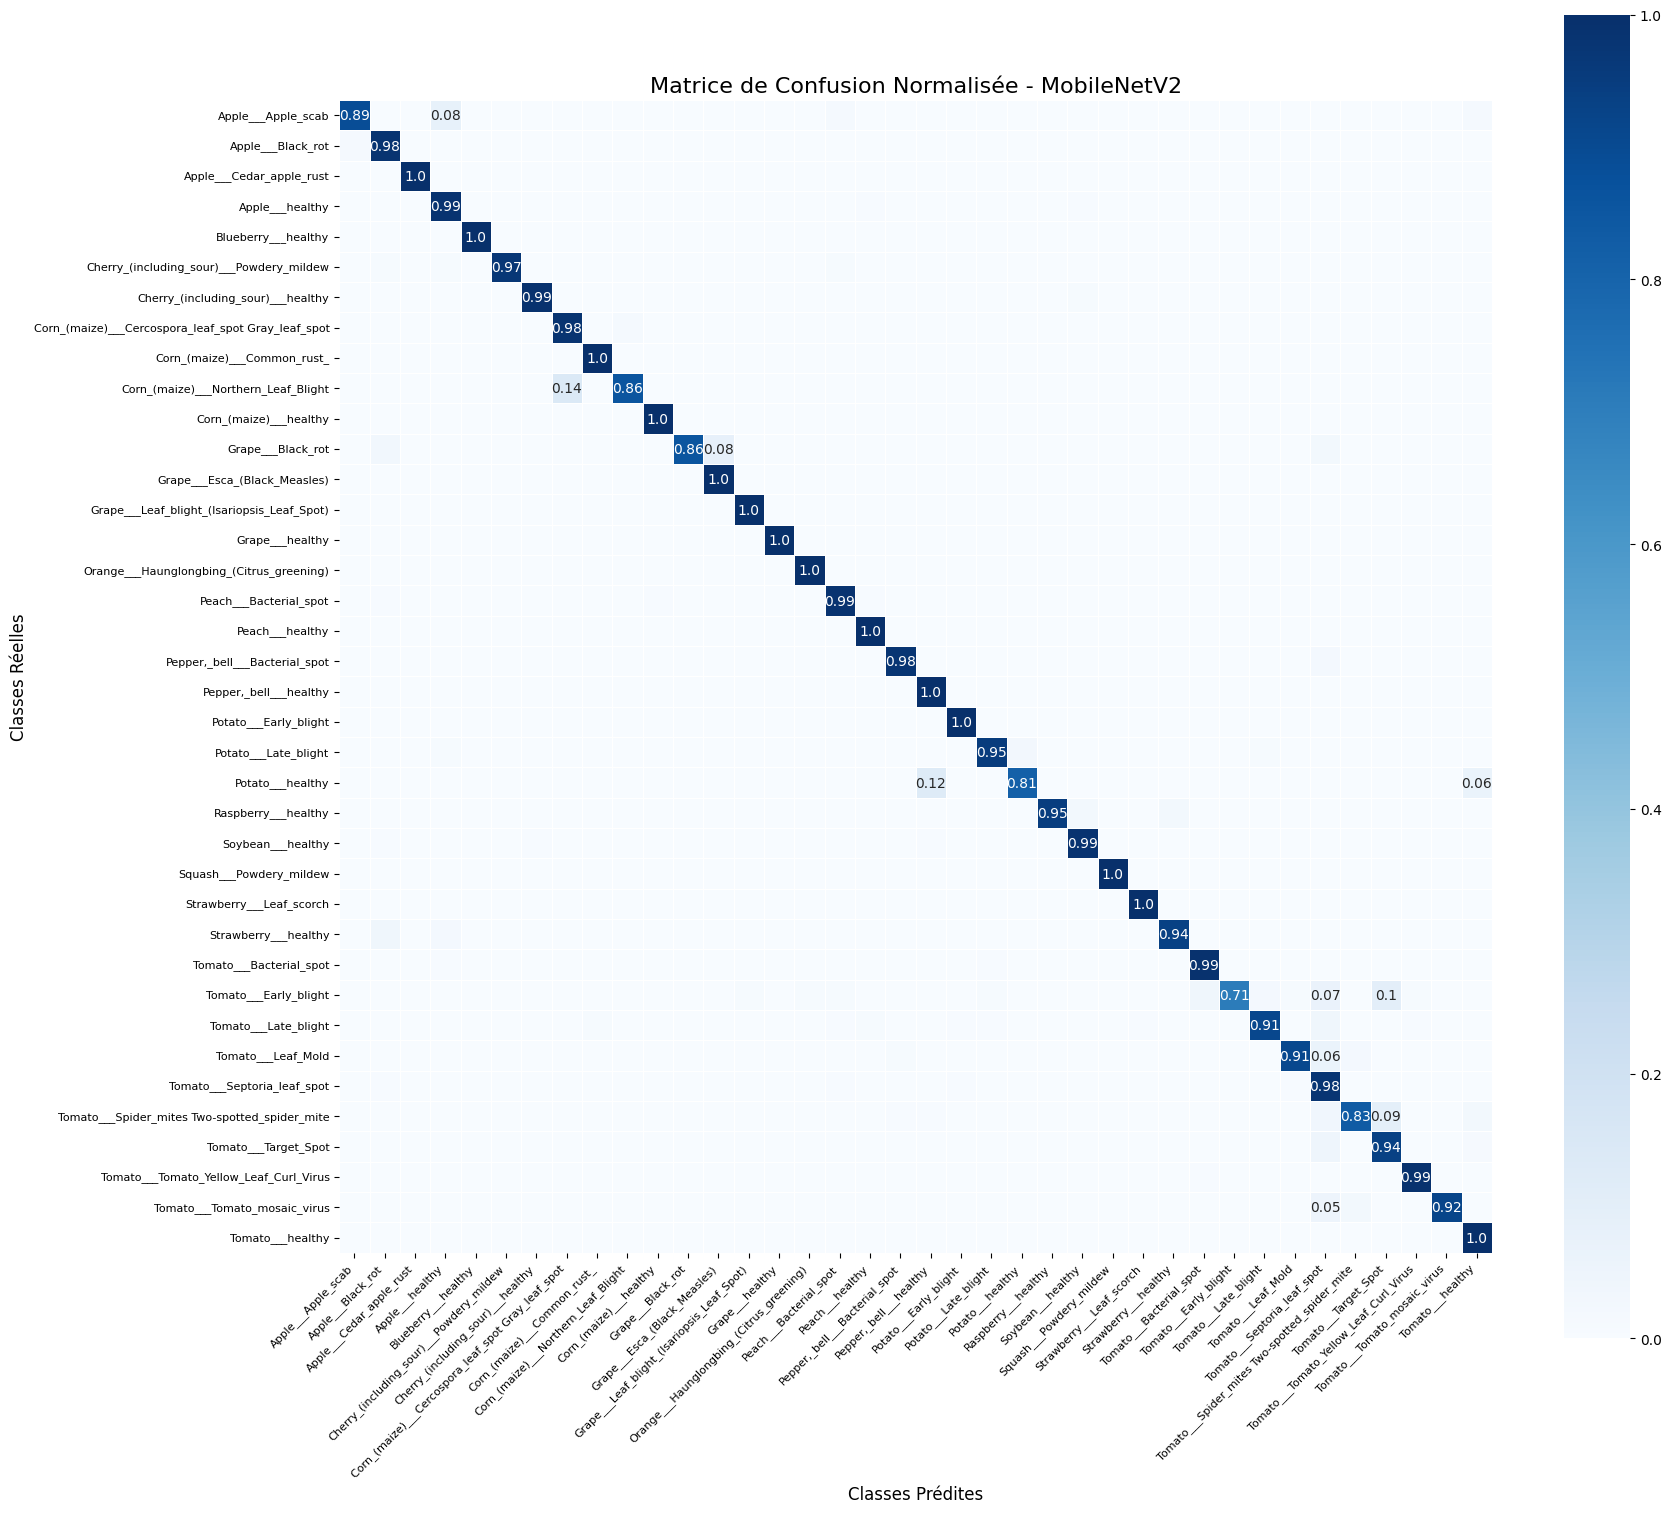

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Générer la matrice de confusion normalisée
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Configurer la taille et les limites d'affichage
plt.figure(figsize=(18, 18))  # Taille augmentée pour une meilleure lisibilité
sns.heatmap(
    cm_normalized,
    annot=np.where(cm_normalized > 0.05, np.round(cm_normalized, 2), ""),  # Afficher uniquement les valeurs significatives
    fmt='',  # Suppression du format standard des annotations
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels,
    linewidths=0.5,  # Séparation des cellules
    square=True,  # Cellules carrées
    cbar_kws={"shrink": 0.8}  # Ajustement de la barre de couleur
)

# Ajuster les étiquettes des axes
plt.xticks(rotation=45, fontsize=8, ha='right')  # Rotation et taille adaptées
plt.yticks(fontsize=8)

# Titres et légendes
plt.title("Matrice de Confusion Normalisée - MobileNetV2", fontsize=16)
plt.xlabel("Classes Prédites", fontsize=12)
plt.ylabel("Classes Réelles", fontsize=12)

# Sauvegarder et afficher
plt.tight_layout()
plt.savefig('confusion_matrix_refined.png', dpi=300)
plt.show()
